<a href="https://colab.research.google.com/github/jdasam/ant5015-2023/blob/main/notebooks/4th_week-auto_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autotagging

In [48]:
import torch
import torchaudio
import IPython.display as ipd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

- Download Small MTAT if you need


In [2]:
!pip install --upgrade gdown
!gdown 15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
# !wget https://sogang365-my.sharepoint.com/:u:/g/personal/dasaem_jeong_o365_sogang_ac_kr/EdkHWV-qvxBEi-d0Ua73VG4BEp7EZO7HMvrXsWqeJvMJzg?e=GbYylV&download=1

!unzip -q mtat_8000.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
From (redirected): https://drive.google.com/uc?id=15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6&confirm=t&uuid=a4dc19f3-207f-4dce-b73c-01df40bce39f
To: /content/mtat_8000.zip
100% 921M/921M [00:04<00:00, 212MB/s]


In [71]:
class MTATDataset:
  def __init__(self, dir_path, split='train', num_max_data=6000, sr=16000):
    self.dir = Path(dir_path)
    self.labels = pd.read_csv(self.dir / "meta.csv", index_col=[0])
    self.sr = sr

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    else: #test
      sub_dir_ids = ['e', 'f', 'g']

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set]
    self.labels = self.labels[:num_max_data]
    self.vocab = self.labels.columns.values[1:-1]
    self.label_tensor = self.convert_label_to_tensor()
  
  def convert_label_to_tensor(self):
    return torch.LongTensor(self.labels.values[:, 1:-1].astype('bool'))

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    info = self.labels.iloc[idx]
    mp3_path = self.dir / info['mp3_path']

    audio, sr = torchaudio.load(mp3_path)
    assert sr == self.sr
    label = self.label_tensor[idx]
    return audio, label

data_dir = Path('MTAT_SMALL')
dataset= MTATDataset(data_dir)
dataset[0]

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -8.8974e-08,
          -5.8156e-08, -5.6856e-08]]),
 tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0]))

In [76]:
dataset.labels

,clip_id,singer,harpsichord,sitar,heavy,foreign,no piano,classical,female,jazz,...,rock,dance,cello,techno,flute,beat,soft,choir,baroque,mp3_path
20552,45147,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2/zephyrus-angelus-11-ave_maria__virgo_serena_...
3899,8539,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,a/tilopa-pictures_of_silence-02-ni-175-204.mp3
8996,19647,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5/arthur_yoria-of_the_lovely-04-several_mistak...
4055,8856,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8/stargarden-music_for_modern_listening-02-per...
6361,13834,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,a/dac_crowell-the_mechanism_of_starlight-03-me...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,3704,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/jay_kishor-cd2_the_sowebo_concert-01-raga_ma...
4704,10328,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8/tim_rayborn-veils_of_light-02-tabak-175-204.mp3
2612,5718,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1/phebe_craig_and_katherine_westine-beside_the...
21389,47024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6/john_williams-dusty_porch-11-talkin_back-88-...


In [10]:
csv_path = data_dir / "meta.csv"
df = pd.read_csv(csv_path)
len(df)
sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']

is_in_set = [True if x[0] in sub_dir_ids else False for x in df['mp3_path'].values.astype('str')]


In [64]:
torch.ones(10, dtype=torch.float) * torch.ones(10, dtype=torch.bool)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [66]:
label_tensor = torch.tensor(df.values[:, 2:-1].astype(bool), dtype=torch.long)
label_tensor[2]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [35]:
mp3_path = data_dir / df.iloc[2]['mp3_path']
y, sr = torchaudio.load(mp3_path)

In [ ]:
ipd.Audio(y, rate=sr, normalize=False)

In [44]:
torchaudio.save('test.wav', y*10, sample_rate=sr)

In [46]:
y_clipped, sr = torchaudio.load('test.wav')

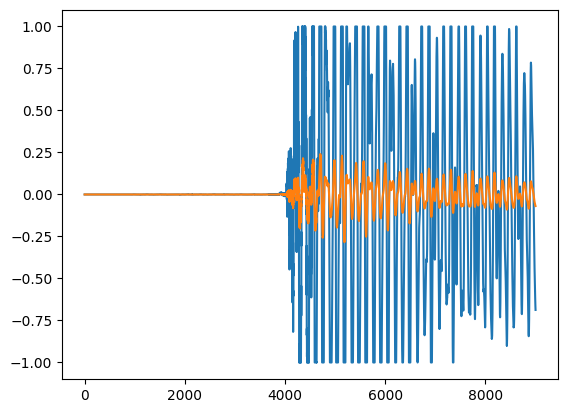

In [50]:
plt.plot(y_clipped[0, 1000:10000])
plt.plot(y[0, 1000:10000])

In [34]:
pwd

'/content'

## Make Dataset

In [72]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

batch = next(iter(data_loader))


In [74]:
audio, label = batch
audio.shape, label.shape

(torch.Size([16, 1, 465984]), torch.Size([16, 49]))

## Make Model

## Train!

## Data Normalization

## How CNN works

In [ ]:
dummy = torch.randint(-3, 4, (2, 6,7)).float()
dummy = dummy.unsqueeze(0)
dummy, dummy.shape

(tensor([[[[ 2.,  3.,  0., -2., -2.,  1., -2.],
           [-3., -3.,  1.,  2., -3.,  1.,  3.],
           [-2.,  1.,  0., -3.,  0., -1., -2.],
           [ 0., -3., -3., -2., -2., -3.,  1.],
           [ 2.,  3.,  2.,  3.,  3., -2., -2.],
           [ 1., -2., -1., -3., -1., -1.,  0.]],
 
          [[ 0.,  0.,  3.,  3., -3., -3.,  0.],
           [-2.,  0.,  2.,  3.,  2., -3., -3.],
           [-1.,  1.,  0., -2.,  3.,  1.,  3.],
           [ 1.,  3.,  0.,  0.,  2.,  3.,  3.],
           [-3.,  2., -3., -3.,  3., -1.,  2.],
           [-3.,  0.,  1., -1.,  1.,  3.,  0.]]]]),
 torch.Size([1, 2, 6, 7]))

In [ ]:
import torch.nn as nn
conv_layer = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, bias=False)
conv_layer.weight

Parameter containing:
tensor([[[[ 0.0329,  0.0913, -0.0989],
          [-0.1222, -0.0248,  0.1674],
          [ 0.0012,  0.0244, -0.2151]],

         [[-0.1140,  0.2020,  0.1060],
          [ 0.0658, -0.0340, -0.0514],
          [-0.0025, -0.1469,  0.1981]]]], requires_grad=True)

In [ ]:
conv_layer.weight.shape # out_channels, in_channels, height, width
conv_layer.weight.data = torch.randint(-1, 2, (1,2,3,3)).float()
conv_layer.weight

Parameter containing:
tensor([[[[ 1.,  1., -1.],
          [ 0., -1., -1.],
          [ 0.,  1.,  0.]],

         [[ 1.,  0.,  0.],
          [-1.,  0.,  1.],
          [ 1.,  1.,  0.]]]], requires_grad=True)

In [ ]:
'''
2D Conv Layer의 입력은 3차원

'''
dummy, conv_layer.weight, conv_layer(dummy)

(tensor([[[[ 2.,  3.,  0., -2., -2.,  1., -2.],
           [-3., -3.,  1.,  2., -3.,  1.,  3.],
           [-2.,  1.,  0., -3.,  0., -1., -2.],
           [ 0., -3., -3., -2., -2., -3.,  1.],
           [ 2.,  3.,  2.,  3.,  3., -2., -2.],
           [ 1., -2., -1., -3., -1., -1.,  0.]],
 
          [[ 0.,  0.,  3.,  3., -3., -3.,  0.],
           [-2.,  0.,  2.,  3.,  2., -3., -3.],
           [-1.,  1.,  0., -2.,  3.,  1.,  3.],
           [ 1.,  3.,  0.,  0.,  2.,  3.,  3.],
           [-3.,  2., -3., -3.,  3., -1.,  2.],
           [-3.,  0.,  1., -1.,  1.,  3.,  0.]]]]),
 Parameter containing:
 tensor([[[[ 1.,  1., -1.],
           [ 0., -1., -1.],
           [ 0.,  1.,  0.]],
 
          [[ 1.,  0.,  0.],
           [-1.,  0.,  1.],
           [ 1.,  1.,  0.]]]], requires_grad=True),
 tensor([[[[ 12.,   6.,  -1.,  -5.,  -8.],
           [ -8.,  -4.,  12.,   5.,   2.],
           [  5.,   8.,   0.,   7.,   7.],
           [ -9., -11.,  -6.,  -1.,   2.]]]], grad_fn=<ThnnConv2DBackw

In [ ]:
conv_layer(dummy[:, 0:3, 1:4])

tensor([[[0.]]], grad_fn=<SqueezeBackward1>)

In [ ]:
num_ch = 4
dummy = torch.randint(-3, 4, (num_ch, 10)).float()
dummy

tensor([[ 2., -3.,  0., -3.,  0.,  2.,  2., -1.,  3.,  1.],
        [-2., -1.,  3., -3.,  2.,  0.,  0.,  2.,  3., -3.],
        [ 1., -2., -3.,  0.,  1.,  3., -3.,  1.,  3., -2.],
        [-1., -2., -2., -3.,  0., -3., -3., -1.,  1.,  3.]])

In [ ]:
out_ch = 6
conv1d = nn.Conv1d(num_ch, out_ch, kernel_size=3, bias=False)
conv1d.weight.data = torch.randint(-1, 2, conv1d.weight.shape).float()
conv1d.weight

Parameter containing:
tensor([[[-1.,  1., -1.],
         [ 0.,  0., -1.],
         [ 1.,  0.,  1.],
         [ 0.,  0.,  0.]],

        [[-1.,  1., -1.],
         [-1.,  1., -1.],
         [ 0.,  1.,  0.],
         [ 1., -1.,  1.]],

        [[ 1., -1., -1.],
         [ 1.,  1.,  1.],
         [-1.,  1., -1.],
         [ 0.,  1.,  1.]],

        [[-1.,  1.,  1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [-1.,  0.,  0.],
         [ 0.,  1.,  1.],
         [ 1., -1.,  1.]],

        [[ 0.,  1., -1.],
         [ 0.,  0., -1.],
         [ 0.,  0., -1.],
         [-1., -1.,  1.]]], requires_grad=True)

In [ ]:
out = conv1d(dummy)
out, out.shape

(tensor([[-10.,   7.,  -7.,   4.,  -2.,   3.,  -9.,   5.],
         [-10.,   7., -10.,   1.,   1.,  -5.,  -7.,  11.],
         [  1.,  -7.,   4., -11.,  -3.,  -8.,   6.,   5.],
         [ -6.,  -1.,  -8.,  -4.,  -5., -11.,  -9.,   4.],
         [ -5., -11.,  -4.,   0.,   2.,   0.,   7.,   3.],
         [ -2.,   7.,  -1.,  -5.,   3.,   5.,  -5.,  10.]],
        grad_fn=<SqueezeBackward1>),
 torch.Size([6, 8]))

In [ ]:
max_pool_layer = nn.MaxPool1d(3)

In [ ]:
after_pool = max_pool_layer(out)
after_pool, after_pool.shape

(tensor([[ 7.,  4.],
         [ 7.,  1.],
         [ 4., -3.],
         [-1., -4.],
         [-4.,  2.],
         [ 7.,  5.]], grad_fn=<SqueezeBackward1>),
 torch.Size([6, 2]))

## Batch Norm

In [ ]:
audio

tensor([[     0.0000,      0.0000,      0.0000,  ...,      0.0000,
             -0.0000,     -0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
             -0.0000,     -0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
              0.0000,      0.0000],
        ...,
        [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
              0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
             -0.0000,     -0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
             -0.0000,     -0.0000]])

In [ ]:
model.train()
model.eval()